# Predict Malignant Neoplasm of Colon

## Introduction - Problem Statement

Colorectal cancer is a malignant tumor arising from the inner wall of the large intestine (colon) or rectum. Colorectal cancer is the third leading cause of cancer in both men and women in the U.S. In this notebook we build a machine learning model that will classify patients who undergo it.

<h3> About Dataset</h3>

Dataset holds 6% of people suffered from Malignant Neoplasm of Colon. And time window is considered before onset of the diagnosis and the entire previous history of records.

<h3>Type of Features considered:</h3>

1)	Demographics - It contains patient level demographic data such as Age, Race and Gender etc

2)	Diagnosis - It contains data about the several conditions the patient has been diagnosed with

3)	Observations - It contains lab measurement details of the patients

4)	Prescriptions - It contains drug details administered to the patients

#### Import Packages

In [1]:
#Packages that are needed to run the notebook
import time
import re
import random
import scipy
import json
import collections 
import psycopg2
import math
import pandas as pd
import numpy as np
import plotly
import datetime as DT
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.plotly as py
import plotly.tools as tls
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import matplotlib
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta
from sqlalchemy import create_engine
from datetime import timedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix,roc_auc_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import label_binarize,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as se
import lightgbm as lgm
from smart_open import smart_open
from sklearn.feature_selection import SelectKBest,chi2,f_classif,RFE,SelectFromModel

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Data Preprocessing is done by using Modularization module 1 and stored it in S3 bucket.

In [2]:
%%time
bucket = 'bucket-name'
object_key_data = 'folder-path/usecasedatamnc.csv'
path_data = 'S3://{}:{}@{}/{}'.format('XXXXXXXXXXXXX', 'XXXXXXXXXXXXXXXXXXXXXXX', bucket, object_key_data)
data = pd.read_csv(smart_open(path_data))

CPU times: user 2.7 s, sys: 505 ms, total: 3.21 s
Wall time: 3.45 s


<h5>Encode methods</h5>

In [3]:
def label_encode(data, col_name):
    encode = LabelEncoder()
    data[col_name] = encode.fit_transform(data[col_name].astype('str'))
    return data


def one_hot_encode(data, col_name):
    dummies = pd.get_dummies(data[col_name], prefix = col_name)
    data = pd.concat([data, dummies], axis=1)
    del data[col_name]
    return data

Remove empty spaces in column names and perform encoding on top of categorical columns

In [4]:
print("Shape of the dataset ",data.shape)

data.columns = data.columns.str.replace(' ', '_')
col_dtypes_list = list(data.select_dtypes(include=['object']).columns)
for c_name_rd in col_dtypes_list:
    data[c_name_rd] = data[c_name_rd].str.replace(' ', '_')
for c_name in col_dtypes_list:
    if data[c_name].nunique()==2:
        data = label_encode(data, c_name)
    else:
        data = one_hot_encode(data, c_name)
final_data = data.drop(columns=['target'],axis=1)
final_data['target'] = data['target']

Shape of the dataset  (48487, 365)


<h4>Feature Selection - LightGBM</h4>

In this usecase, feature selection is performed using LightGBM. It is a gradient boosting framework that uses tree based learning algorithm and it grows tree vertically.

The parameters tweaked are<br>
<li><b>max_depth</b>- 15, Lower max depth taken to handle model overfitting</li>
<li><b>learning_rate</b> - 0.001, Small learning rate considered for better accuracy</li>
<li><b>num_leaves</b>    - 900, To deal with overfitting</li>

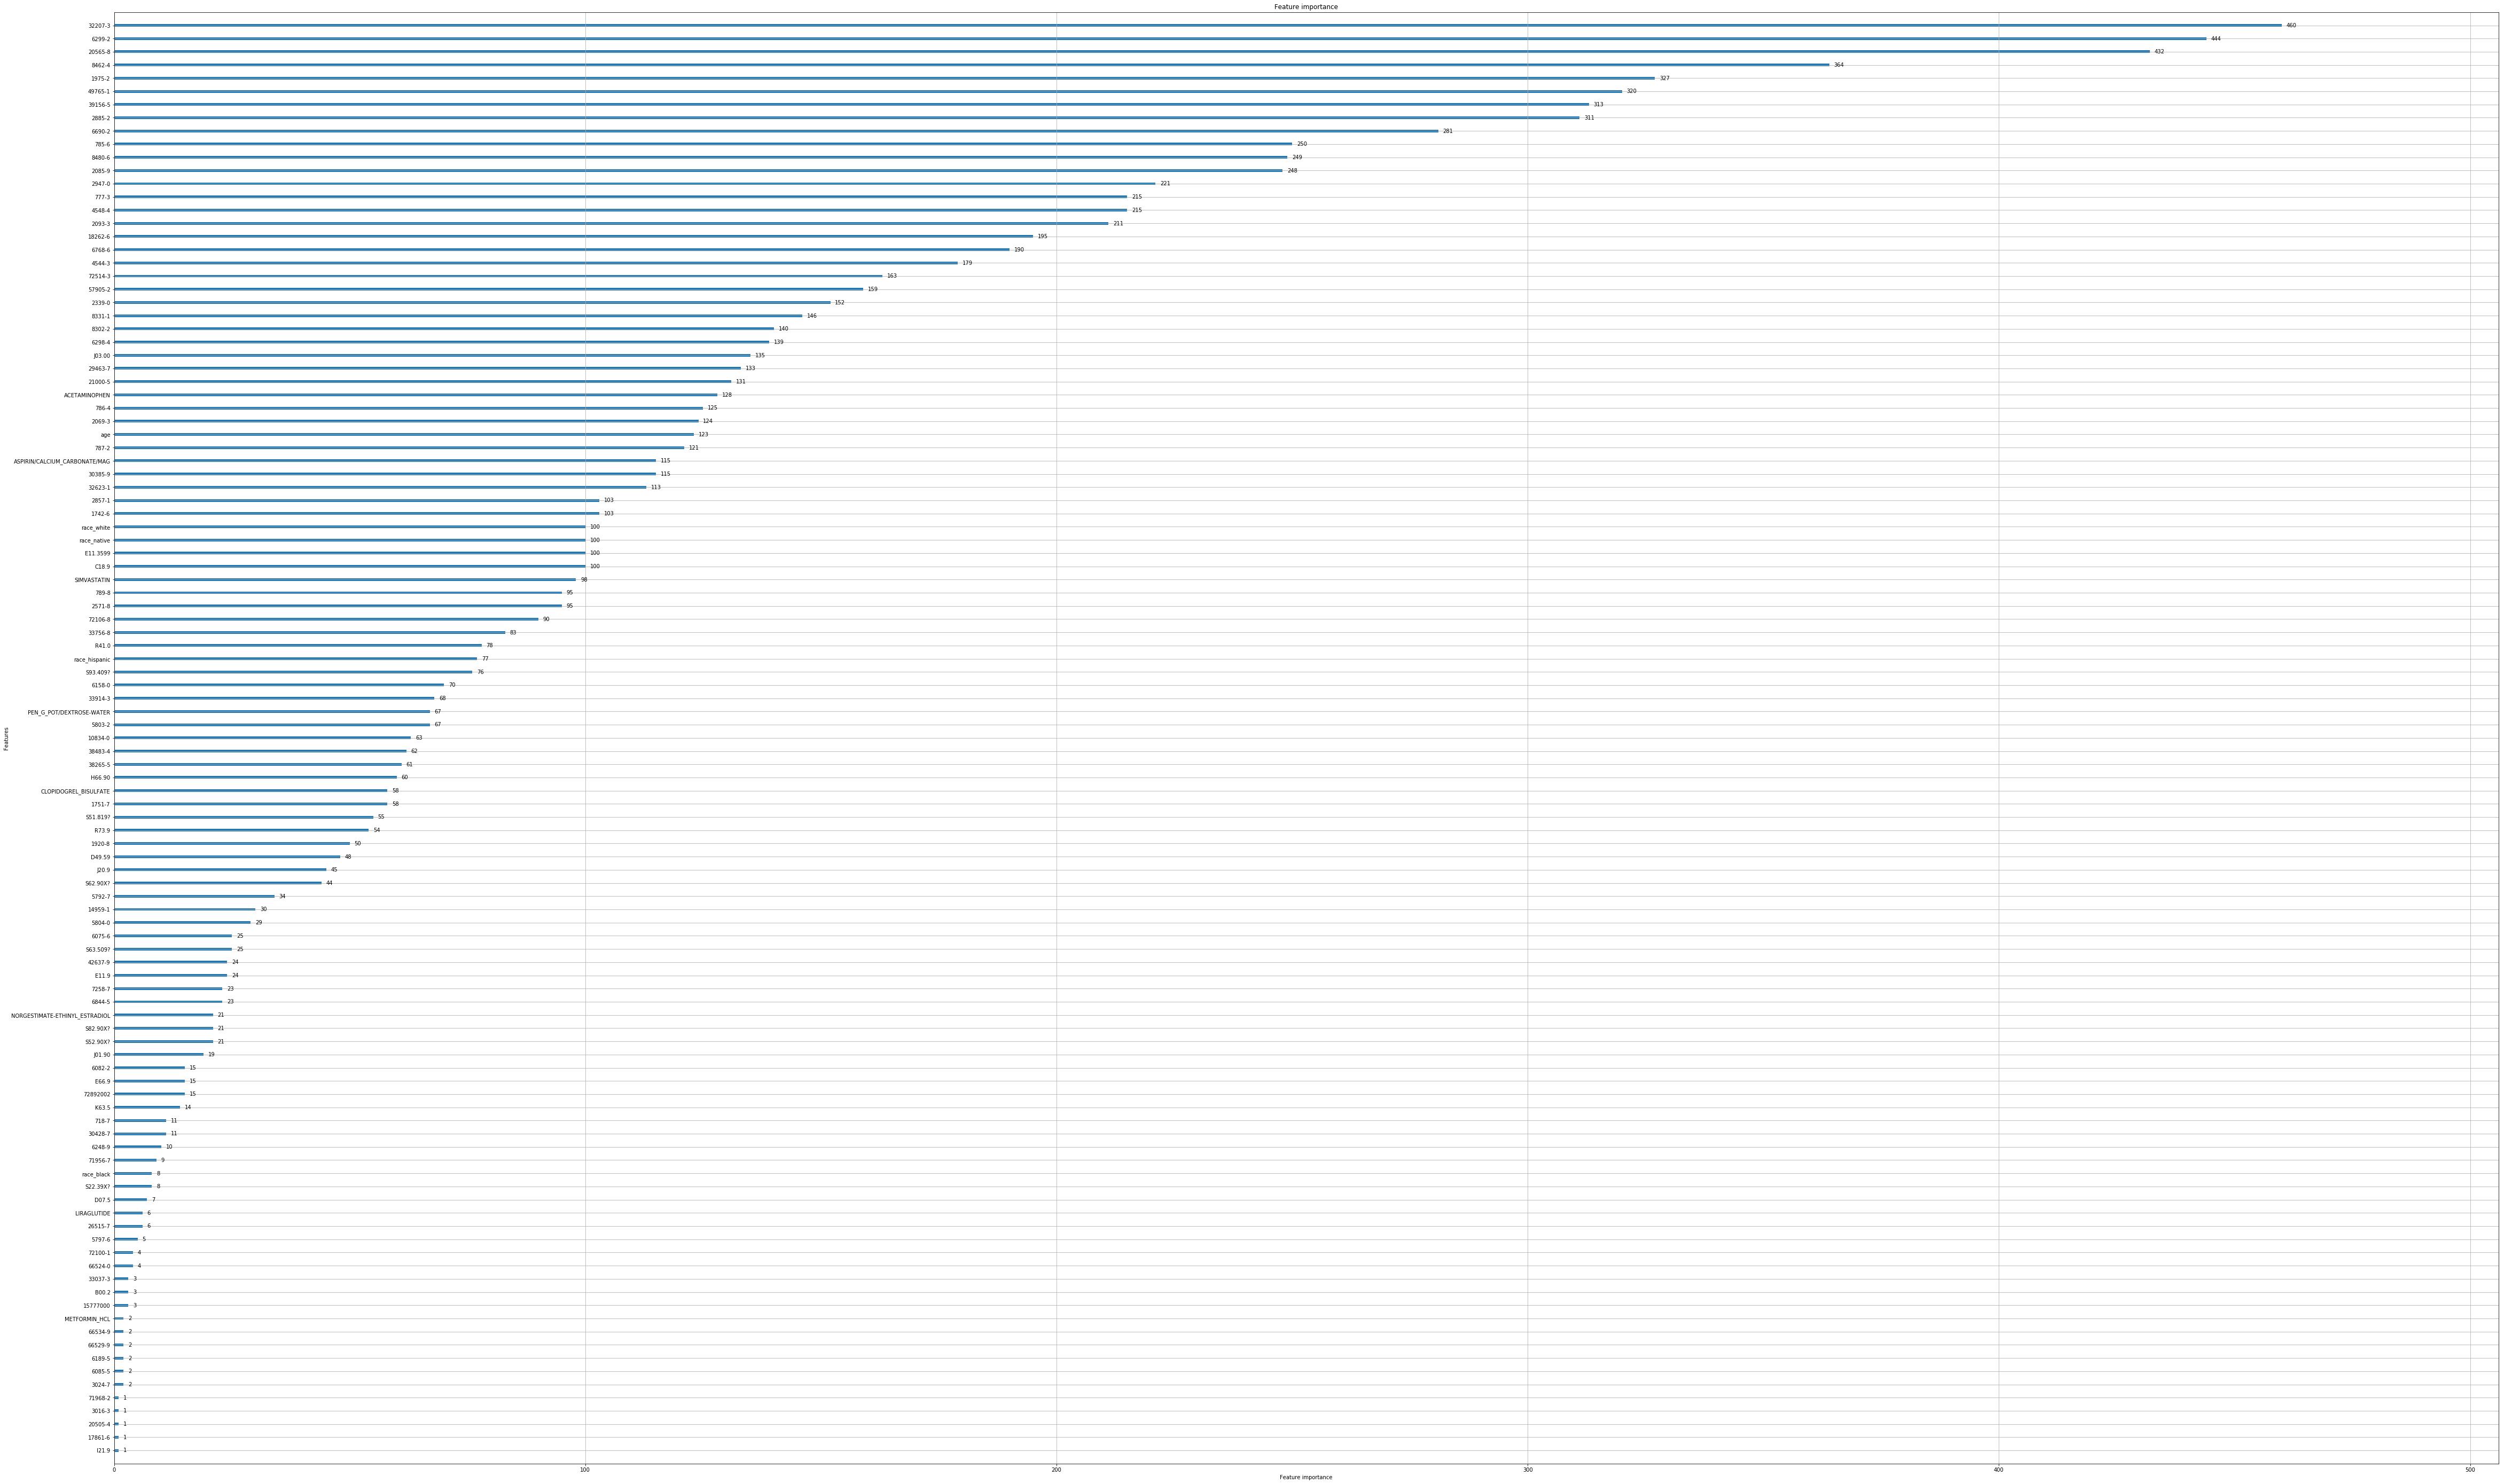

In [5]:
col_to_drop = ['target']
lgbm_features = final_data.drop(col_to_drop,axis=1)
lgbm_labels = final_data['target']

lgbm_data = lgm.Dataset(lgbm_features,label=lgbm_labels)
params = {"max_depth":15, "learning_rate":0.001, "num_leaves":900}
lgm_model = lgm.train(params=params,train_set=lgbm_data,categorical_feature='auto')
lgm_plot = lgm.plot_importance(lgm_model,max_num_features=370,figsize=(80,50))

Retriving features which has high feature importance score

In [6]:
this = list(lgm_model.feature_importance())
effe_cols = []
for i in this:
    if i > 249:
        effe_cols.append(lgm_model.feature_name()[this.index(i)])
        this[this.index(i)]=0        
model_data = lgbm_features[effe_cols]
model_data['target'] = lgbm_labels

Based on the Feature importance score and after performing several iterations the final dataframe in which machine learning models are applied have top 10 features and the feature importance score considered is 249 and above. Column description are given below.

<h4>Data Analysis</h4>

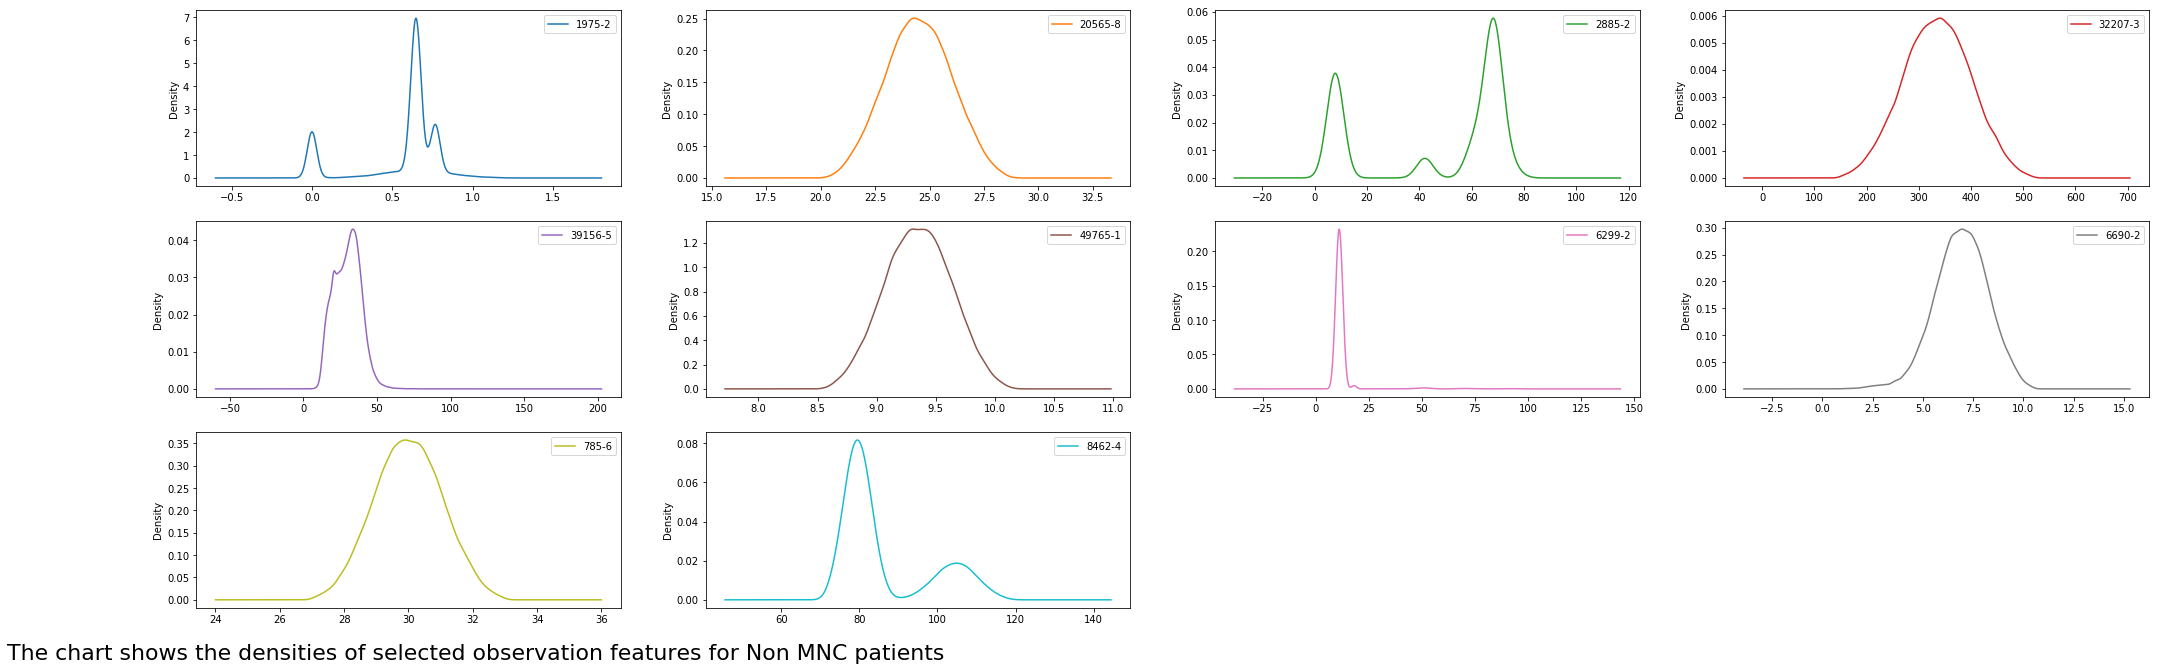

In [25]:
final_data0 = model_data[model_data['target']==0][['1975-2','20565-8','2885-2','32207-3','39156-5','49765-1','6299-2','6690-2','785-6','8462-4']]
final_data0.plot(kind='density', subplots=True, layout=(3,4), sharex=False,figsize=(35,10))
plt.subplots_adjust(bottom=0.05)
text="The chart shows the densities of selected observation features for Non MNC patients"
plt.figtext(0.05,0.00, text, fontsize=22, va="top", ha="left")
plt.show()

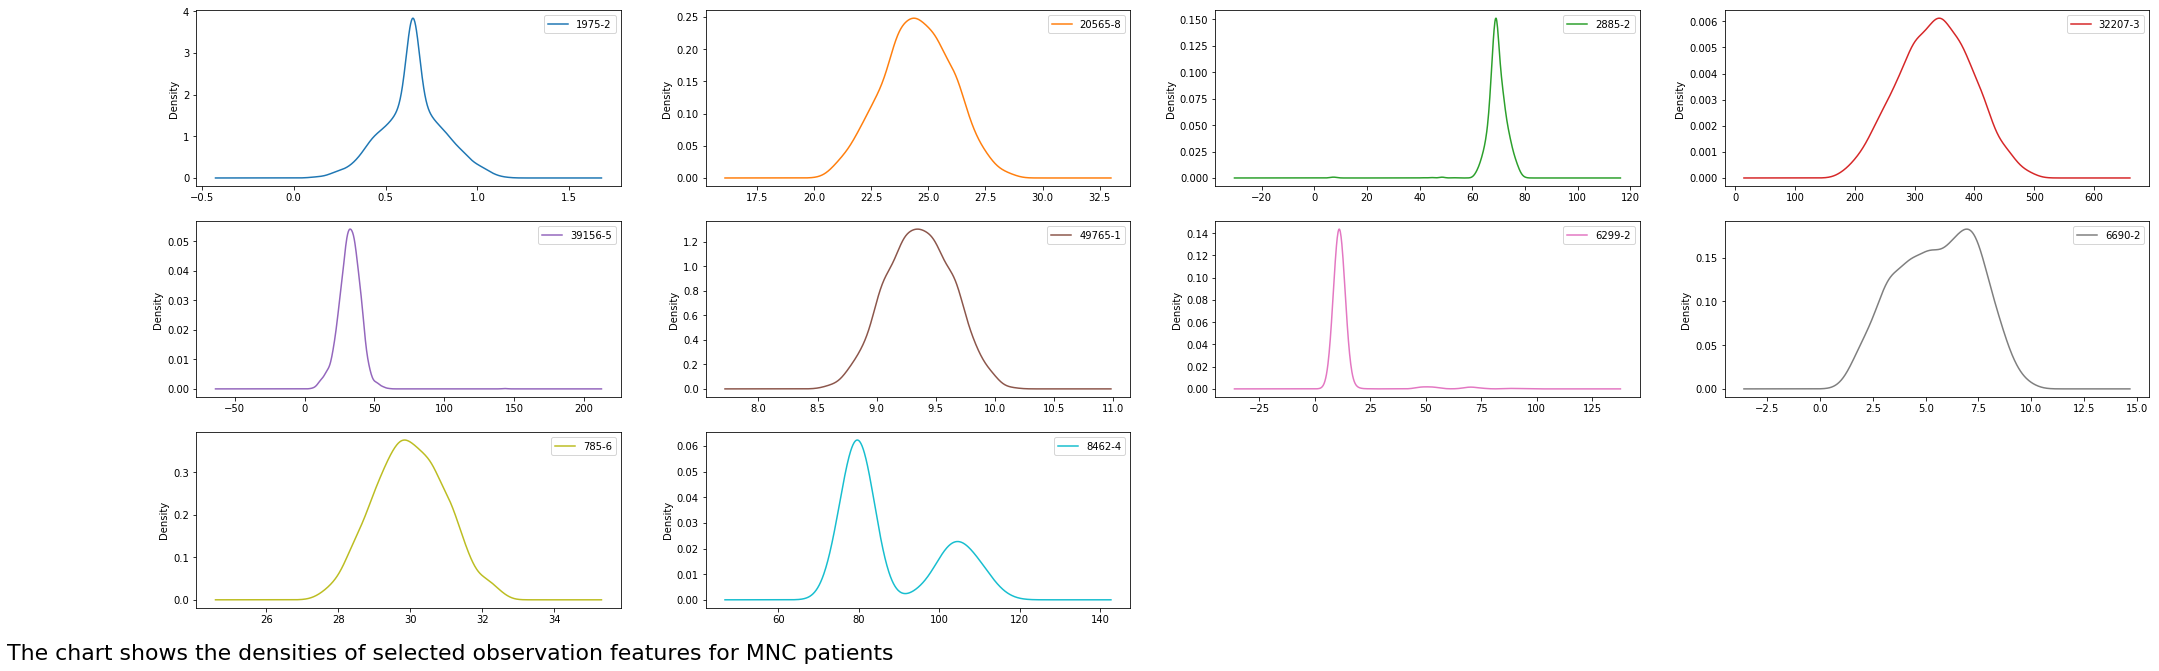

In [24]:
final_data1 = model_data[model_data['target']==1][['1975-2','20565-8','2885-2','32207-3','39156-5','49765-1','6299-2','6690-2','785-6','8462-4']]
final_data1.plot(kind='density', subplots=True, layout=(3,4), sharex=False,figsize=(35,10))
plt.subplots_adjust(bottom=0.05)
text="The chart shows the densities of selected observation features for MNC patients"
plt.figtext(0.05,0.00, text, fontsize=22, va="top", ha="left")
plt.show()

<h5>Train Test Split</h5>

In [7]:
def split_train_test(df):
    labels = df['target'].values
    features = df.drop(['target'], axis=1).values
    print("Enter the test set split size else press <enter> to move on. It takes default as 0.3")
    test_ss = input()
    if len(test_ss)!=0:
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = float(test_ss), random_state = 1)
        train_test=[train_features, test_features, train_labels, test_labels]
    else:
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 1)
        train_test=[train_features, test_features, train_labels, test_labels]
    return train_test

data_list = split_train_test(model_data)  

Enter the test set split size else press <enter> to move on. It takes default as 0.3
0.3


<h5>Model Building</h5>

In [8]:
# Model
lr = LogisticRegression(class_weight={1:0.85,0:0.15})
model_list = []
model_list.append(('LR',lr))

This function is to evaluate perfomance of algorithm on a base level. The outputs of this function are the model metrics

Acc: 0.94 AUC: 0.84 Recall: 0.33 Precision: 0.27
TN , FP 
FN, TP
[[13418   533]
 [  398   198]]


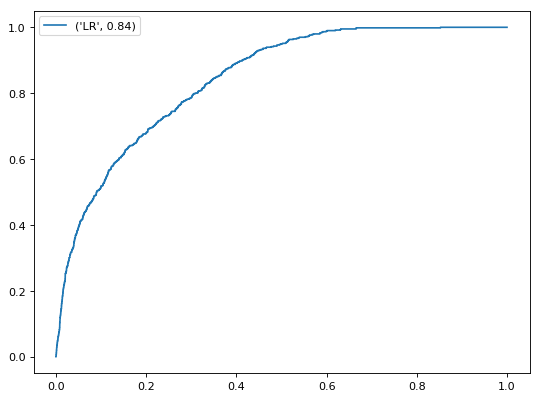

In [9]:
def compare_models(data_list):
    from matplotlib.pyplot import figure
    modelname = []
    modelaccuracy = []
    model_roc_auc_score = []
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    train_features = data_list[0]
    test_features = data_list[1]
    train_labels = data_list[2]
    test_labels = data_list[3]
        
    for model_name,select_model in model_list:
        fit_model = select_model.fit(train_features,train_labels)
        model_predict = fit_model.predict(test_features)
        # Predict Probability
        probability_1 = select_model.predict_proba(test_features)[:,1]        
        probability_0 = select_model.predict_proba(test_features)[:,0]
        p1_gt90 = [p90 for p90 in probability_1 if p90 >= .9]
        p0_gt90 = [p90 for p90 in probability_0 if p90 >= .9]
        model_accuracy = round(accuracy_score(test_labels,model_predict),2)
        model_recall = round(recall_score(test_labels,model_predict),2)
        model_precision = round(precision_score(test_labels,model_predict),2)
        roc_auc_score_model = round(roc_auc_score(test_labels,probability_1),2)
        model_msg = "%s %f %f" % (model_name, model_accuracy, roc_auc_score_model)
        model_confu = confusion_matrix(test_labels,model_predict)
        modelname.append(model_name)
        modelaccuracy.append(model_accuracy)
        model_roc_auc_score.append(roc_auc_score_model)
        test_labels_binary = label_binarize(test_labels, classes=[0,1])
        fpr, tpr, threshold = roc_curve(test_labels_binary, probability_1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = (model_name, round(roc_auc,2)))
        plt.legend(loc='upper left')
        #print(model_name+' Acc: '+str(model_accuracy)+' AUC: '+str(roc_auc_score_model) +' Recall: '+str(model_recall)+' Precision: '+str(model_precision)+' FPR: '+str(round(fpr[1],2)) + ' TPR: '+str(round(tpr[1],2)))
        print (('Acc: %r' % model_accuracy)+ (' AUC: %r' % roc_auc_score_model ) + (' Recall: %r' % model_recall ) + (' Precision: %r' % model_precision ))
        print ('TN , FP \nFN, TP')
        print (model_confu)
        model_lr = os.path.join(os.path.pardir,'MNC','lr.pkl')
        model_pickle_lr = open(model_lr,'wb')
        pickle.dump(fit_model,model_pickle_lr)
        model_pickle_lr.close()
        
compare_models(data_list)

<h4>Probability Prediction</h4>

Number of patients having 90% probability of predicting having MNC:  11
Number of patients having 90% probability of predicting doesn't having MNC:  6883
Number of patients having 95% probability of predicting having MNC:  0
Number of patients having 95% probability of predicting doesn't having MNC:  5358
Number of patients having 99% probability of predicting having MNC:  0
Number of patients having 99% probability of predicting doesn't having MNC:  4579


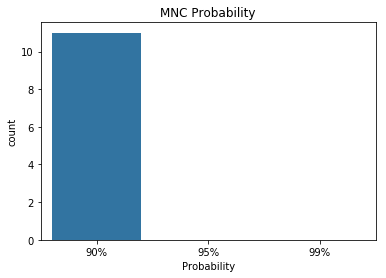

In [27]:
#Function to perform probability prediction
def probability_prediction(trn_ft,tst_ft,trn_lbl,tst_lbl):
    train_features = trn_ft
    test_features = tst_ft
    train_labels = trn_lbl
    test_labels = tst_lbl  
    fit_model = lr.fit(train_features,train_labels)
    model_predict = fit_model.predict(test_features)
    probability_1 = lr.predict_proba(test_features)[:,1]
    probability_0 = lr.predict_proba(test_features)[:,0]
    p1_gt90 = [p90 for p90 in probability_1 if p90 >= .9]
    p0_gt90 = [p90 for p90 in probability_0 if p90 >= .9]
    p1_gt95 = [p95 for p95 in probability_1 if p95 >= .95]
    p0_gt95 = [p95 for p95 in probability_0 if p95 >= .95]
    p1_gt99 = [p99 for p99 in probability_1 if p99 >= .99]
    p0_gt99 = [p99 for p99 in probability_0 if p99 >= .99]
    print("Number of patients having 90% probability of predicting having MNC: ", len(p1_gt90))
    print("Number of patients having 90% probability of predicting doesn't having MNC: ", len(p0_gt90))
    print("Number of patients having 95% probability of predicting having MNC: ", len(p1_gt95))
    print("Number of patients having 95% probability of predicting doesn't having MNC: ", len(p0_gt95))
    print("Number of patients having 99% probability of predicting having MNC: ", len(p1_gt99))
    print("Number of patients having 99% probability of predicting doesn't having MNC: ", len(p0_gt99))
    ckd_per = ['90%','95%','99%']
    ckd_val = [len(p1_gt90),len(p1_gt95),len(p1_gt99)]
    ckd_set = {'Probability':ckd_per,'count':ckd_val}
    ckd_df = pd.DataFrame(ckd_set)
    se.barplot(x=ckd_df['Probability'],y=ckd_df['count'])
    plt.title('MNC Probability')
        
probability_prediction(data_list[0],data_list[1],data_list[2],data_list[3])

# END